## Commentary:

__This file is trying to do too many things.  We want to know if regularization can help us model the dataset more accurately in order to have more confidence in predictions.__

__What this code does, though, is to change the game from the previous model.  That model does a polynomial expansion of time and size while leaving the (18) one-hot encoded categorical variable $state$ unexpanded.__

__That model has the benefit of restricting the number of terms of the expansion for computational efficiency.  The number of features in the expansion scales polynomially in the number of features of the input, and exponentially in the degree.  As we increase the degree, the subsequent feature explosion leads to serious issues.  For example, the full second degree polynomial for _time_, _size_ and all the _state_ features has 231 terms.  The 3rd degree expansion contains 2300 features.  By 6th degree we would be up to around 1.5M features.__

__Keeping in mind that we want to fit a model to over 300k rows of data, this begins to look seriously unmanageable.__

__In the model_4 notebook, we achieved $R^2$ of 0.53 with a 14th degree polynomial (without expanding the _state_ variables).__

__In this code, we're having issues with 4th degree models for ridge and OLS due to huge number of features.  Best fit alpha for ridge is 100.  This is not where we're supposed to be if Ridge is helping us -- alpha should be << 1.0.__

__The next step should be trying polynomial model without including one-hot vars in expansion.  The experiments below show that those polynomial terms do not help to improve performance without other techniques (feature selection?).__

## Use ridge regression to model instead of OLS

Try ridge regression to see if regularization is helpful.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 8))
np.set_printoptions(precision=4, suppress=False)
# please show all columns
pd.set_option("display.max_columns", 60)
import seaborn as sns
sns.set()

In [2]:
# Import sklearn stuff

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline,  make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

In [3]:
# read cleaned data
dfModelAll = pd.read_csv('../local/data/LBNL_openpv_tts_data/ModelAll.csv', index_col='row', dtype={'state':'category'})

In [4]:
# note data is sorted by time
dfModelAll.head()

,num_days,size_kw,state,cost_per_watt,scaleSize
row,,,,,
0,0.0,2.2824,CA,10.734315,0
1,21.0,1.8504,CA,11.108701,0
2,26.0,2.3076,CA,8.667013,0
3,84.0,2.3316,CA,13.270286,0
4,111.0,0.9300,CA,14.654839,0


In [5]:
dfModelAll.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 364212 entries, 0 to 364211
Data columns (total 5 columns):
num_days         364212 non-null float64
size_kw          364212 non-null float64
state            364212 non-null category
cost_per_watt    364212 non-null float64
scaleSize        364212 non-null int64
dtypes: category(1), float64(3), int64(1)
memory usage: 14.2 MB


### Check out number of terms in polynomial expansion

In [6]:
# the independent variables
numFeatures =[]
live_vars = ['num_days', 'size_kw', 'state']
# downsize by 10,000
dfmini = dfModelAll.sample(frac=0.0001)
dfmini = pd.get_dummies(dfmini[live_vars], drop_first=True)
for i in range(1, 8): 
    # print(i)
    poly_mini = PolynomialFeatures(degree=i).fit_transform(dfmini)
    numFeatures.append(poly_mini.shape[1])
numFeatures

[21, 231, 1771, 10626, 53130, 230230, 888030]

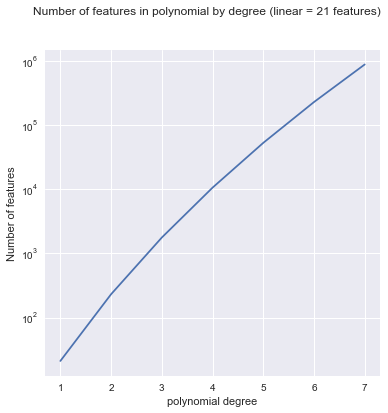

In [7]:
fig, ax = plt.subplots(figsize=(6, 6))
sTitle = 'Number of features in polynomial by degree (linear = 21 features)'
fig.suptitle(sTitle)
ax.set_ylabel('Number of features')
ax.set_xlabel('polynomial degree')
ax.semilogy(np.arange(1.0, len(numFeatures) + 1), np.array(numFeatures));

### make a small dataset to try out the pipeline

#### let's do the one hot encoding with pandas

In [8]:
dfMod100k = dfModelAll.sample(n=10000); dfMod100k.head()

,num_days,size_kw,state,cost_per_watt,scaleSize
row,,,,,
86054,4637.0,7.320,CA,4.193716,2
355214,6901.0,8.215,CA,2.015581,3
129566,5236.0,2.535,CA,5.978304,1
319703,6772.0,9.975,CA,4.554737,3
29154,3486.0,4.800,CA,8.442177,1


### do one-hot encoding of $state$

In [9]:
dfMod100k = pd.get_dummies(dfMod100k, drop_first=True)

In [10]:
dfMod100k.head()

,num_days,size_kw,cost_per_watt,scaleSize,state_AZ,state_CA,state_CT,state_DE,state_FL,state_MA,state_MD,state_MN,state_NH,state_NJ,state_NM,state_NV,state_NY,state_OR,state_PA,state_TX,state_VT,state_WI
row,,,,,,,,,,,,,,,,,,,,,,
86054,4637.0,7.320,4.193716,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
355214,6901.0,8.215,2.015581,3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
129566,5236.0,2.535,5.978304,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
319703,6772.0,9.975,4.554737,3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
29154,3486.0,4.800,8.442177,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Important: since the data is sorted by time, it needs to be shuffed first or cross_val_score will pick bad sets.

In [11]:
# now the whole model; shuffle it though
dfMod = pd.get_dummies(dfModelAll, drop_first=True).sample(frac=1.0)

### Regress on time, size and state

In [12]:
theCols = dfMod100k.columns; theCols

Index(['num_days', 'size_kw', 'cost_per_watt', 'scaleSize', 'state_AZ',
       'state_CA', 'state_CT', 'state_DE', 'state_FL', 'state_MA', 'state_MD',
       'state_MN', 'state_NH', 'state_NJ', 'state_NM', 'state_NV', 'state_NY',
       'state_OR', 'state_PA', 'state_TX', 'state_VT', 'state_WI'],
      dtype='object')

### Try ridge on small dataset, simple model, vary alpha.

#### chose one of these cells to set X and y

In [13]:
# prep data and target; this is about 30% of the data
X = dfMod100k[['num_days', 'size_kw', 'state_AZ',
              'state_CA', 'state_CT', 'state_DE', 'state_FL', 'state_MA', 'state_MD',
              'state_MN', 'state_NH', 'state_NJ', 'state_NM', 'state_NV', 'state_NY',
              'state_OR', 'state_PA', 'state_TX', 'state_VT', 'state_WI']]
y = dfMod100k[['cost_per_watt']]

In [14]:
# prep data and target
# X = dfMod[['num_days', 'size_kw', 'state_AZ',
#               'state_CA', 'state_CT', 'state_DE', 'state_FL', 'state_MA', 'state_MD',
#               'state_MN', 'state_NH', 'state_NJ', 'state_NM', 'state_NV', 'state_NY',
#               'state_OR', 'state_PA', 'state_TX', 'state_VT', 'state_WI']]
# y = dfMod[['cost_per_watt']]

In [15]:
### Helper to plot cv score vs alpha
def display_plot(cv_scores, cv_scores_std):
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(1,1,1) 
    ax.plot(alpha_space, cv_scores)
    std_error = cv_scores_std / np.sqrt(10)
    
    ax.fill_between(alpha_space, cv_scores + std_error, cv_scores - std_error, alpha=0.2)
    ax.set_ylabel('CV Score +/- Std Error')
    ax.set_xlabel('Alpha')
    ax.axhline(np.max(cv_scores), linestyle='--', color='.5')
    ax.set_xlim([alpha_space[0], alpha_space[-1]])
    ax.set_xscale('log')
    plt.show()

### Vary alpha to see what looks good (if anything).  There's not much chance we're overfitting with a linear model so regularization should not do anything useful.  Compare to OLS regressor.

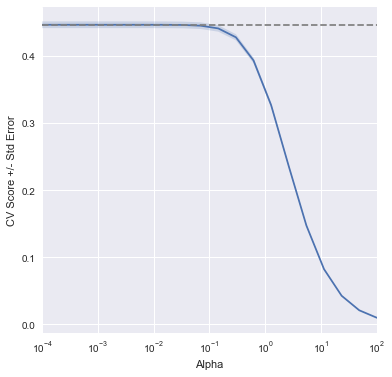

In [16]:
### Just mess with alpha to see what looks good (if anything).
### There's not much chance we're overfitting with a linear model.
### Compare to OLS regressor.
from sklearn.linear_model import Ridge

# Setup the array of alphas and lists to store scores
alpha_space = np.logspace(-4, 2, 20)
ridge_scores = []
ridge_scores_std = []

# Create a ridge regressor: ridge
ridge = Ridge(normalize=True)

# Compute scores over range of alphas
for alpha in alpha_space:
    # Specify the alpha value to use: ridge.alpha
    ridge.alpha = alpha   
    # Perform 4-fold CV: ridge_cv_scores
    ridge_cv_scores = cross_val_score(ridge, X, y, cv=4)
    # Append the mean of ridge_cv_scores to ridge_scores
    ridge_scores.append(np.mean(ridge_cv_scores))  
    # Append the std of ridge_cv_scores to ridge_scores_std
    ridge_scores_std.append(np.std(ridge_cv_scores))

# print scores and std
# print('ridge scores: {}'.format(ridge_scores))
# print('ridge scores std: {}'.format(ridge_scores_std))

# Display the plot
display_plot(ridge_scores, ridge_scores_std)

### OLS does just as well on this model

In [17]:
pLR = Pipeline([('scale', StandardScaler()), 
                ('OLS', LinearRegression())])

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
model = pLR
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print('R^2 train: %.3f, R^2 test: %.3f' % 
      (r2_score(y_train, y_train_pred),
       r2_score(y_test, y_test_pred)))


R^2 train: 0.447, R^2 test: 0.452


In [18]:
# cross_val_score needs the data randomized not sorted that's why this works with small dataset but gives garbage for full ds.
cross_val_score(pLR, X, y, cv=4)

array([0.4599, 0.4433, 0.4224, 0.4627])

### Conclusion: Ridge doesn't do anything useful with this model. 

Alpha from 0 to about 0.1 doesn't help or hurt.  More than that and $R^2$ goes down.

Regularization helps a model with enough complexity to capture the trend not overfit (by weakening terms that don't help the model).

Next we add some complexity to the model.

### End of trial of ridge with simple model...

---

### Now try straightforward polynomial transformation (including the one-hot encoded state in the expansion)

### Build a pipeline that does the right thing

Treat all input variables the same (i.e. polynomial expansion includes state one-hot columns).

In [19]:
# Scale, poly then Ridge
# for now use tiny alpha to make equivalent to OLS
thePolyRidgePipe = Pipeline([
    ('scale', StandardScaler()),
    ('poly', PolynomialFeatures()),
    ('Ridge', Ridge(normalize=False, alpha=0.001))
]) # end of Pipeline

In [20]:
thePolyRidgePipe.get_params()

{'Ridge': Ridge(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=None,
    normalize=False, random_state=None, solver='auto', tol=0.001),
 'Ridge__alpha': 0.001,
 'Ridge__copy_X': True,
 'Ridge__fit_intercept': True,
 'Ridge__max_iter': None,
 'Ridge__normalize': False,
 'Ridge__random_state': None,
 'Ridge__solver': 'auto',
 'Ridge__tol': 0.001,
 'memory': None,
 'poly': PolynomialFeatures(degree=2, include_bias=True, interaction_only=False),
 'poly__degree': 2,
 'poly__include_bias': True,
 'poly__interaction_only': False,
 'scale': StandardScaler(copy=True, with_mean=True, with_std=True),
 'scale__copy': True,
 'scale__with_mean': True,
 'scale__with_std': True,
 'steps': [('scale', StandardScaler(copy=True, with_mean=True, with_std=True)),
  ('poly',
   PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)),
  ('Ridge', Ridge(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001))]}

### Do  not run Ridge pipe on the full dataset - this takes a while; actually a ridulously long time; need verbose set to true in grid_search_cv.

##### This is example output from cell below
```
# Specify the hyperparameter space.
poly_space = np.arange(1, 4)
alpha_space = np.logspace(-4, 0, 5)
# Create the hyperparameter grid, just poly degree up to 6th
param_grid = {'poly__degree': poly_space,
              'Ridge__alpha': alpha_space}

Fitting 4 folds for each of 15 candidates, totalling 60 fits
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:   22.2s finished
Best parameters: {'Ridge__alpha': 1.0, 'poly__degree': 3}
test R squared: 0.474783779159491
```

Fitting 4 folds for each of 15 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:   24.7s finished


Best parameters: {'Ridge__alpha': 100.0, 'poly__degree': 3}
test R squared: 0.5015083733979022


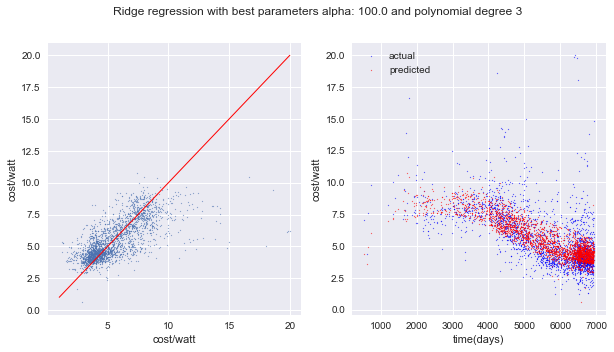

In [21]:
# use 100k data points for test
X = dfMod100k[['num_days', 'size_kw', 'state_AZ',
              'state_CA', 'state_CT', 'state_DE', 'state_FL', 'state_MA', 'state_MD',
              'state_MN', 'state_NH', 'state_NJ', 'state_NM', 'state_NV', 'state_NY',
              'state_OR', 'state_PA', 'state_TX', 'state_VT', 'state_WI']]
y = dfMod100k[['cost_per_watt']]

# Specify the hyperparameter space.
poly_space = np.arange(1, 4)
alpha_space = np.logspace(-2, 2, 5)
# Create the hyperparameter grid, just poly degree up to 6th
param_grid = {'poly__degree': poly_space,
              'Ridge__alpha': alpha_space}

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Create the GridSearchCV object: gm_cv
gs_cv = GridSearchCV(thePolyRidgePipe, param_grid, cv=4, return_train_score=True, verbose=True)

# Fit to the training set
model = gs_cv.fit(X_train, y_train)

# Compute and print the metrics
r2 = model.score(X_test, y_test)
print("Best parameters: {}".format(gs_cv.best_params_))
print("test R squared: {}".format(r2))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sTitle = 'Ridge regression with best parameters alpha: {} and polynomial degree {}'
fig.suptitle(sTitle.format(gs_cv.best_params_['Ridge__alpha'],
                           gs_cv.best_params_['poly__degree']))

ax1.scatter(y_test, model.predict(X_test), marker='.', s=4, alpha=0.5);
ax1.plot(np.array([1,20]), np.array([1,20]), linewidth=1, color='red')
ax1.set_ylabel('cost/watt')
ax1.set_xlabel('cost/watt')

ax2.scatter(X_test.iloc[:, 0], y_test, marker='.', color='blue', s=4, alpha=0.5, label='actual')
ax2.scatter(X_test.iloc[:, 0], model.predict(X_test), marker='.', color='red', s=4, alpha=0.5, label='predicted')
ax2.set_ylabel('cost/watt')
ax2.set_xlabel('time(days)')
ax2.legend()
plt.show();

### Take a look at the best model i.e. {'Ridge__alpha': 100.0, 'poly__degree': 3} )

In [22]:
bestE = model.best_estimator_

In [23]:
bestE.steps

[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)),
 ('poly',
  PolynomialFeatures(degree=3, include_bias=True, interaction_only=False)),
 ('Ridge', Ridge(alpha=100.0, copy_X=True, fit_intercept=True, max_iter=None,
     normalize=False, random_state=None, solver='auto', tol=0.001))]

In [24]:
bestE.steps[-1][1].coef_

array([[ 0.0000e+00, -5.3622e-01, -2.5845e-01, ...,  1.4476e-06,
        -3.3365e-07,  6.0007e-05]])

In [25]:
bestE.steps[-1][1].intercept_

array([5.3182])

In [26]:
bestE.steps[-1][1].coef_.shape

(1, 1771)

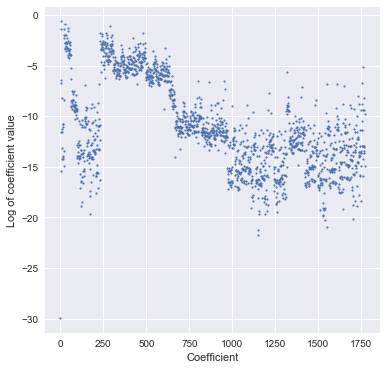

In [27]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1) 

ax.scatter(np.arange(bestE.steps[-1][1].coef_.size), 
           np.log(np.abs(bestE.steps[-1][1].coef_ + 0.0000000000001)),
           s=3);
ax.set_xlabel('Coefficient')
ax.set_ylabel('Log of coefficient value');

In [28]:
model.cv_results_

{'mean_fit_time': array([0.0095, 0.0494, 0.7856, 0.0075, 0.0459, 0.9137, 0.0113, 0.092 ,
        0.8084, 0.0073, 0.0494, 0.8039, 0.0083, 0.0476, 0.8552]),
 'mean_score_time': array([0.0038, 0.0078, 0.0797, 0.0025, 0.009 , 0.0917, 0.0015, 0.0085,
        0.09  , 0.0013, 0.0073, 0.0985, 0.0015, 0.0073, 0.1025]),
 'mean_test_score': array([0.4434, 0.4702, 0.4736, 0.4434, 0.4702, 0.4738, 0.4434, 0.4702,
        0.4749, 0.4434, 0.4702, 0.4797, 0.4434, 0.4704, 0.4838]),
 'mean_train_score': array([0.4484, 0.4851, 0.5144, 0.4484, 0.4851, 0.5144, 0.4484, 0.4851,
        0.5144, 0.4484, 0.4851, 0.5144, 0.4483, 0.4848, 0.5141]),
 'param_Ridge__alpha': masked_array(data=[0.01, 0.01, 0.01, 0.1, 0.1, 0.1, 1.0, 1.0, 1.0, 10.0,
                    10.0, 10.0, 100.0, 100.0, 100.0],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_poly__degree': ma

In [29]:
thing = pd.DataFrame(model.cv_results_)

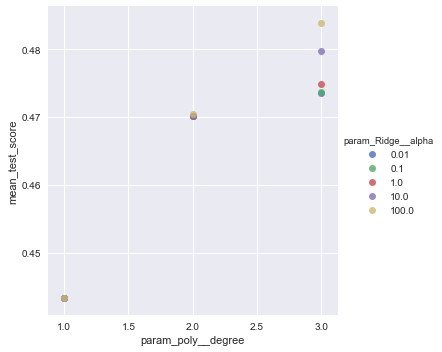

In [30]:
sns.lmplot('param_poly__degree', 'mean_test_score', hue='param_Ridge__alpha', data=thing, fit_reg=False);

In [31]:
def trainVsTest(results):
    mean_train_scores = results['mean_train_score']
    mean_test_scores = results['mean_train_score']
    n = len(mean_train_scores)
    # print(mean_train_scores, mean_test_scores)
    # 
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    sTitle = 'train/test scores vs parameters'
    fig.suptitle(sTitle.format(gs_cv.best_params_['poly__degree']))

    ax.scatter(np.arange(1, n + 1), mean_train_scores, marker='d', s=100, alpha=1, color='green', label='train');
    ax.scatter(np.arange(1, n + 1), mean_test_scores, marker='+', s=100, alpha=0.5, color='red', label='test');
    ax.set_ylabel('score')
    ax.set_xlabel('param combination')

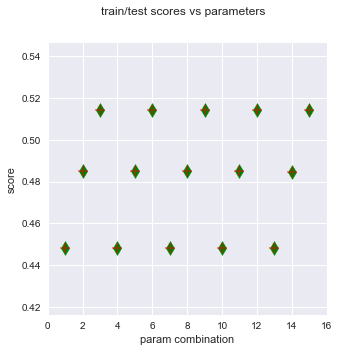

In [32]:
trainVsTest(model.cv_results_)

### Interesting, now substitute OLS and see what happens.  This is different from previous model because all the one-hot encoded vars participate in poly expansion.

In [33]:
# change to OLS 
# all vars get scaled, then go to polynomial
thePolyOLSPipe = Pipeline([
    ('scale', StandardScaler()),
    ('poly', PolynomialFeatures()),
    ('OLS', LinearRegression())
]) # end of Pipeline

Fitting 4 folds for each of 3 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   13.7s finished


Best parameters: {'poly__degree': 2}
test R squared: 0.4901763903933912


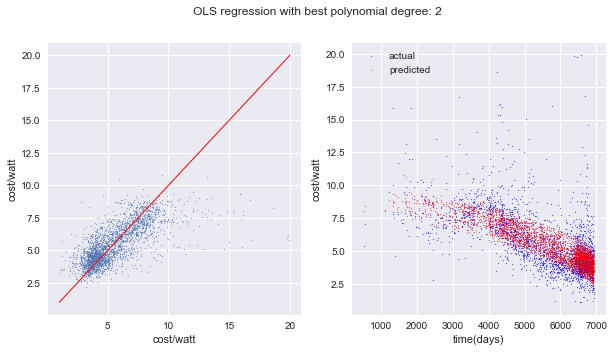

In [34]:
# use 100k data points for test
X = dfMod100k[['num_days', 'size_kw', 'state_AZ',
              'state_CA', 'state_CT', 'state_DE', 'state_FL', 'state_MA', 'state_MD',
              'state_MN', 'state_NH', 'state_NJ', 'state_NM', 'state_NV', 'state_NY',
              'state_OR', 'state_PA', 'state_TX', 'state_VT', 'state_WI']]
y = dfMod100k[['cost_per_watt']]

# poly degrees 1, 2 and 3
poly_space = np.arange(1, 4)
# no alpha for this pipleline
# alpha_space = np.logspace(-4, 0, 5)

# Create the hyperparameter grid, just poly degree up to 4th
param_grid = {'poly__degree': poly_space} # ,
#              'Ridge__alpha': alpha_space}

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

# Create the GridSearchCV object: gm_cv
gs_cv = GridSearchCV(thePolyOLSPipe, param_grid, cv=4, return_train_score=True, verbose=True)

# Fit to the training set
model = gs_cv.fit(X_train, y_train)

# Compute and print the metrics
r2 = model.score(X_test, y_test)
print("Best parameters: {}".format(gs_cv.best_params_))
print("test R squared: {}".format(r2))

# plot best model on test set
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sTitle = 'OLS regression with best polynomial degree: {}'
fig.suptitle(sTitle.format(gs_cv.best_params_['poly__degree']))

ax1.scatter(y_test, model.predict(X_test), marker='.', s=4, alpha=0.5);
ax1.plot(np.array([1,20]), np.array([1,20]), linewidth=1, color='red')
ax1.set_ylabel('cost/watt')
ax1.set_xlabel('cost/watt')

ax2.scatter(X_test.iloc[:, 0], y_test, marker='.', color='blue', s=4, alpha=0.5, label='actual')
ax2.scatter(X_test.iloc[:, 0], model.predict(X_test), marker='.', color='red', s=4, alpha=0.5, label='predicted')
ax2.set_ylabel('cost/watt')
ax2.set_xlabel('time(days)')
ax2.legend()
plt.show();

In [35]:
model.cv_results_

{'mean_fit_time': array([0.0088, 0.0963, 3.0098]),
 'mean_score_time': array([0.002 , 0.0158, 0.0978]),
 'mean_test_score': array([0.446 , 0.4707, 0.4643]),
 'mean_train_score': array([0.4486, 0.4827, 0.5106]),
 'param_poly__degree': masked_array(data=[1, 2, 3],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'poly__degree': 1}, {'poly__degree': 2}, {'poly__degree': 3}],
 'rank_test_score': array([3, 1, 2]),
 'split0_test_score': array([0.4204, 0.4314, 0.4605]),
 'split0_train_score': array([0.4566, 0.4928, 0.5199]),
 'split1_test_score': array([0.4519, 0.477 , 0.4852]),
 'split1_train_score': array([0.4464, 0.4812, 0.51  ]),
 'split2_test_score': array([0.4739, 0.4974, 0.4419]),
 'split2_train_score': array([0.4398, 0.4752, 0.5033]),
 'split3_test_score': array([0.4377, 0.4771, 0.4695]),
 'split3_train_score': array([0.4517, 0.4816, 0.5093]),
 'std_fit_time': array([0.0024, 0.0079, 0.0549]),
 'std_score_time': array([7.6331e-0

### What does the above say?

It says as poly degree goes up training score goes up but test score dives off a cliff (very large negative $R^2$).
The best $R^2$ is 0.45 at poly degree 1 (i.e. linear).  So this proves that driving the state one-hot vars through the poly expansion does not help.  